# BTC Market Descriptive Statistics, Tests, and Plots

This notebook loads Binance and Kraken BTC data, computes basis/spread metrics, runs summary/test tables, and exports plot artifacts for reporting.

Event windows used (UTC):
- **Pre**: 2023-03-01 to 2023-03-09
- **Event**: 2023-03-10 to 2023-03-13
- **Post**: 2023-03-14 to 2023-03-21

## 1) Set Up Environment and Imports

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")
sns.set_theme(style="whitegrid", context="talk")

ROOT = Path(".")
DATA_DIR = ROOT / "IAQF_Parshva" / "IAQF" / "data"
OUT_DIR = ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Data dir:", DATA_DIR.resolve())
print("Output dir:", OUT_DIR.resolve())

Data dir: C:\Users\Shreya Sandurkar\Downloads\IAQF\IAQF_Parshva\IAQF\data
Output dir: C:\Users\Shreya Sandurkar\Downloads\IAQF\outputs


## 2) Load Data into DataFrames

We load Binance BTCUSD/BTCUSDC and Kraken BTCUSDC files used in the paper analysis.

In [2]:
binance_usd = pd.read_csv(DATA_DIR / "binance_btc_usd.csv")
binance_usdc = pd.read_csv(DATA_DIR / "binance_btc_usdc.csv")
kraken_usdc = pd.read_csv(DATA_DIR / "kraken_btc_usdc.csv")

print("Shapes:")
print("binance_usd:", binance_usd.shape)
print("binance_usdc:", binance_usdc.shape)
print("kraken_usdc:", kraken_usdc.shape)

display(binance_usd.head(3))
display(binance_usdc.head(3))
display(kraken_usdc.head(3))

Shapes:
binance_usd: (30240, 13)
binance_usdc: (30240, 13)
kraken_usdc: (15719, 8)


,symbol,timestamp,open,high,low,close,volume,quote_volume,n_trades,taker_buy_base_volume,taker_buy_quote_volume,open_time_ms,close_time_ms
0,BTCUSD,2023-03-01 00:00:00+00:00,"23,144.780000","23,152.480000","23,133.110000","23,143.720000",3.912156,"90,547.214564",116,2.865766,"66,331.479341",1677628800000,1677628859999
1,BTCUSD,2023-03-01 00:01:00+00:00,"23,146.320000","23,152.490000","23,139.020000","23,143.670000",2.685574,"62,157.518814",47,0.526573,"12,189.946737",1677628860000,1677628919999
2,BTCUSD,2023-03-01 00:02:00+00:00,"23,141.360000","23,161.520000","23,139.420000","23,156.030000",3.509939,"81,262.059090",101,2.505903,"58,025.866415",1677628920000,1677628979999


,symbol,timestamp,open,high,low,close,volume,quote_volume,n_trades,taker_buy_base_volume,taker_buy_quote_volume,open_time_ms,close_time_ms
0,BTCUSDC,2023-03-01 00:00:00+00:00,"23,143.820000","23,152.650000","23,140.020000","23,152.650000",0.263950,"6,109.000799",9,0.221380,"5,123.793068",1677628800000,1677628859999
1,BTCUSDC,2023-03-01 00:01:00+00:00,"23,152.650000","23,152.650000","23,152.650000","23,152.650000",0.000000,0.000000,0,0.000000,0.000000,1677628860000,1677628919999
2,BTCUSDC,2023-03-01 00:02:00+00:00,"23,152.650000","23,152.650000","23,152.650000","23,152.650000",0.000000,0.000000,0,0.000000,0.000000,1677628920000,1677628979999


,timestamp,datetime_utc,open,high,low,close,volume,trades
0,1677628800,2023-03-01 00:00:00+00:00,"23,151.530000","23,151.530000","23,150.000000","23,150.000000",0.021259,2
1,1677628860,2023-03-01 00:01:00+00:00,"23,148.360000","23,148.360000","23,148.360000","23,148.360000",0.004918,1
2,1677628980,2023-03-01 00:03:00+00:00,"23,158.940000","23,160.100000","23,158.940000","23,160.100000",0.000351,2


## 3) Clean and Validate Data

Standardize timestamps, enforce numeric types, remove duplicate timestamps, and merge to aligned minute-level panel.

In [3]:
def prep_binance(df: pd.DataFrame, out_col: str) -> pd.DataFrame:
    d = df.copy()
    d["timestamp"] = pd.to_datetime(d["timestamp"], utc=True)
    d[out_col] = pd.to_numeric(d["close"], errors="coerce")
    d = d[["timestamp", out_col]].dropna().drop_duplicates(subset=["timestamp"])
    return d


def prep_kraken(df: pd.DataFrame, out_col: str) -> pd.DataFrame:
    d = df.copy()
    d["timestamp"] = pd.to_datetime(d["datetime_utc"], utc=True)
    d[out_col] = pd.to_numeric(d["close"], errors="coerce")
    d = d[["timestamp", out_col]].dropna().drop_duplicates(subset=["timestamp"])
    return d


b_usd = prep_binance(binance_usd, "binance_usd_close")
b_usdc = prep_binance(binance_usdc, "binance_usdc_close")
k_usdc = prep_kraken(kraken_usdc, "kraken_usdc_close")

df = b_usd.merge(b_usdc, on="timestamp", how="inner").merge(k_usdc, on="timestamp", how="inner")

assert df["timestamp"].is_unique, "Timestamp is not unique after merge"

print("Merged shape:", df.shape)
print("Date range:", df["timestamp"].min(), "to", df["timestamp"].max())
df.head()

Merged shape: (15719, 4)
Date range: 2023-03-01 00:00:00+00:00 to 2023-03-21 23:58:00+00:00


,timestamp,binance_usd_close,binance_usdc_close,kraken_usdc_close
0,2023-03-01 00:00:00+00:00,"23,143.720000","23,152.650000","23,150.000000"
1,2023-03-01 00:01:00+00:00,"23,143.670000","23,152.650000","23,148.360000"
2,2023-03-01 00:03:00+00:00,"23,156.830000","23,152.650000","23,160.100000"
3,2023-03-01 00:04:00+00:00,"23,176.690000","23,171.830000","23,162.000000"
4,2023-03-01 00:08:00+00:00,"23,139.150000","23,178.510000","23,138.850000"


## 4) Compute Summary Tables

Create basis/spread metrics, period labels, descriptive stats, and null-rate checks.

In [4]:
def assign_period(ts: pd.Timestamp) -> str | None:
    pre_start = pd.Timestamp("2023-03-01", tz="UTC")
    event_start = pd.Timestamp("2023-03-10", tz="UTC")
    post_start = pd.Timestamp("2023-03-14", tz="UTC")
    end = pd.Timestamp("2023-03-22", tz="UTC")

    if pre_start <= ts < event_start:
        return "pre"
    if event_start <= ts < post_start:
        return "event"
    if post_start <= ts < end:
        return "post"
    return None


df["usdc_basis"] = df["binance_usdc_close"] - df["binance_usd_close"]
df["usdc_basis_pct"] = 100.0 * df["usdc_basis"] / df["binance_usd_close"]
df["binance_kraken_spread"] = df["binance_usdc_close"] - df["kraken_usdc_close"]
df["period"] = df["timestamp"].map(assign_period)
df = df[df["period"].notna()].copy()

metrics = ["usdc_basis", "binance_kraken_spread", "usdc_basis_pct"]

summary_stats = (
    df[metrics]
    .agg(["count", "mean", "std", "median", "min", "max"])
    .T
    .rename(columns={"count": "n", "std": "std_dev"})
)

null_rates = df[metrics].isna().mean().rename("null_rate")
summary_stats = summary_stats.join(null_rates)

summary_stats

,n,mean,std_dev,median,min,max,null_rate
usdc_basis,"15,719.000000",170.948542,438.887049,9.110000,-171.610000,"2,873.930000",0.000000
binance_kraken_spread,"15,719.000000",-7.788652,143.535788,0.520000,"-2,225.930000",711.620000,0.000000
usdc_basis_pct,"15,719.000000",0.824466,2.164208,0.037552,-0.657510,14.307520,0.000000


## 5) Build Grouped and Pivot Tables

In [5]:
period_order = ["pre", "event", "post"]

period_means = (
    df.groupby("period")[["usdc_basis", "binance_kraken_spread", "usdc_basis_pct"]]
    .mean()
    .reindex(period_order)
)

period_pivot = pd.pivot_table(
    df,
    index="period",
    values=["usdc_basis", "binance_kraken_spread", "usdc_basis_pct"],
    aggfunc=["mean", "std", "count"],
).reindex(period_order)

period_means, period_pivot

(        usdc_basis  binance_kraken_spread  usdc_basis_pct
 period                                                   
 pre       0.500513              -0.840095        0.002250
 event   591.523924             -28.788447        2.875515
 post     16.429972               1.124511        0.063999,
                         mean                                             std  \
        binance_kraken_spread usdc_basis usdc_basis_pct binance_kraken_spread   
 period                                                                         
 pre                -0.840095   0.500513       0.002250             11.262662   
 event             -28.788447 591.523924       2.875515            269.286263   
 post                1.124511  16.429972       0.063999             26.282978   
 
                                                  count             \
        usdc_basis usdc_basis_pct binance_kraken_spread usdc_basis   
 period                                                              
 pre  

## 6)–8) Statistical Tests and Visualizations

- Distribution plots (hist/KDE and box plots)
- Comparison plots (period bars and scatter)
- Time-series plots with event shading

,metric,comparison,n_a,n_b,mean_a,mean_b,t_stat,t_pvalue,var_a,var_b,f_stat,f_pvalue
0,usdc_basis,pre vs event,4930,4360,0.500513,591.523924,-58.296076,0.000000,83.690014,"448,069.606826",0.000187,0.000000
1,usdc_basis,event vs post,4360,6429,591.523924,16.429972,56.688570,0.000000,"448,069.606826",955.469695,468.952191,0.000000
2,usdc_basis,pre vs post,4930,6429,0.500513,16.429972,-39.145175,0.000000,83.690014,955.469695,0.087590,0.000000
3,binance_kraken_spread,pre vs event,4930,4360,-0.840095,-28.788447,6.847777,0.000000,126.847547,"72,515.091464",0.001749,0.000000
4,binance_kraken_spread,event vs post,4360,6429,-28.788447,1.124511,-7.311223,0.000000,"72,515.091464",690.794910,104.973402,0.000000
5,binance_kraken_spread,pre vs post,4930,6429,-0.840095,1.124511,-5.383401,0.000000,126.847547,690.794910,0.183625,0.000000


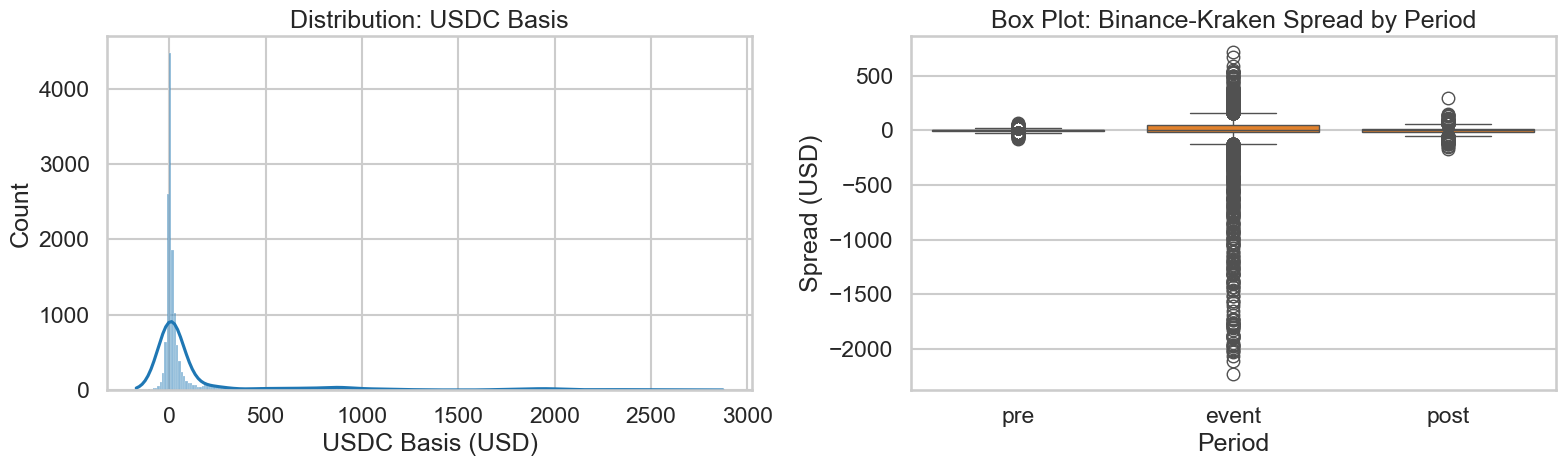

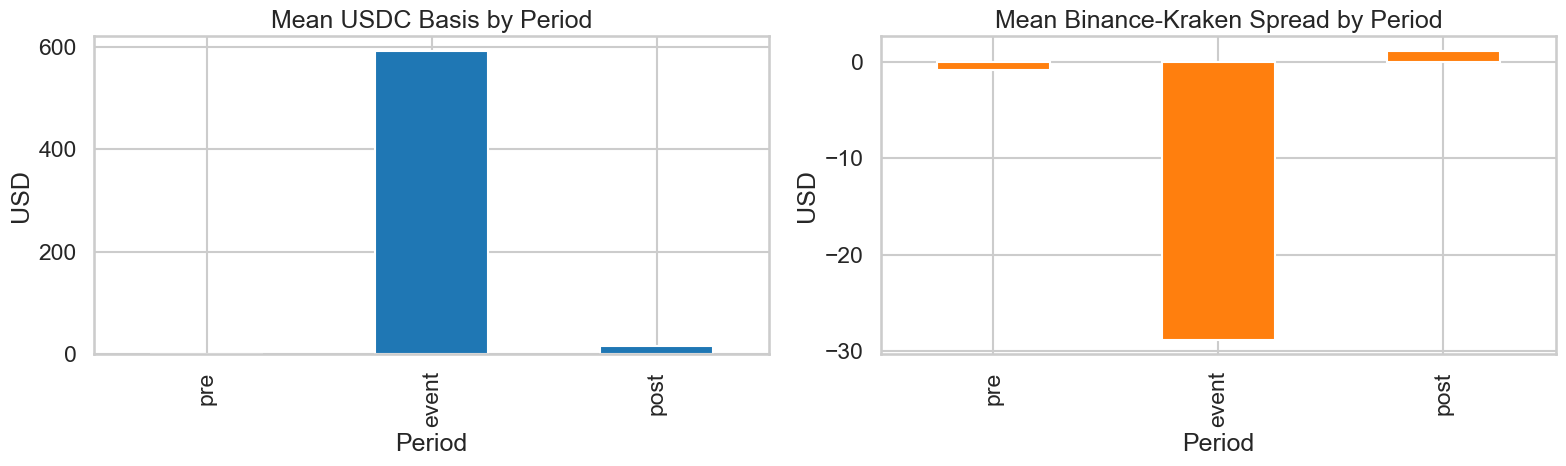

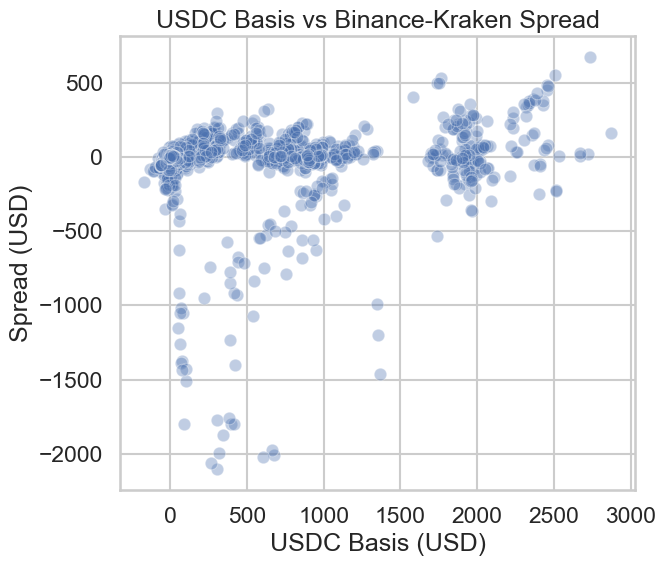

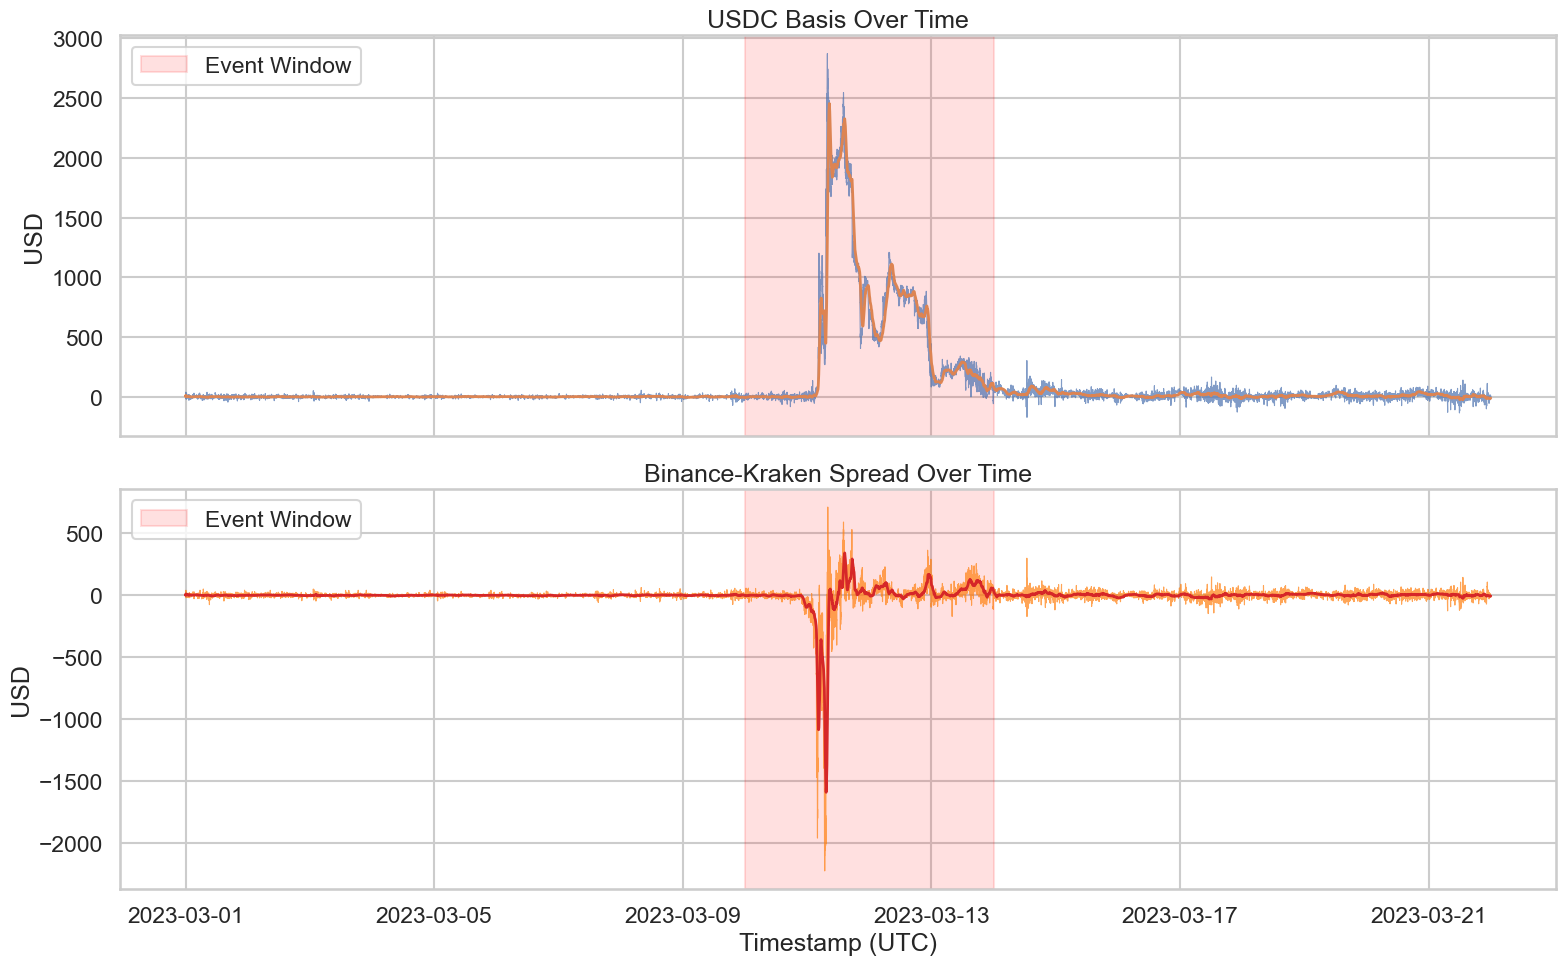

In [6]:
def f_test_two_sided(x: pd.Series, y: pd.Series) -> tuple[float, float]:
    x = x.dropna()
    y = y.dropna()
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    f_stat = var_x / var_y
    df1 = len(x) - 1
    df2 = len(y) - 1
    cdf_val = stats.f.cdf(f_stat, df1, df2)
    p_two_sided = 2 * min(cdf_val, 1 - cdf_val)
    return f_stat, p_two_sided


def pairwise_tests(data: pd.DataFrame, metric: str) -> pd.DataFrame:
    pairs = [("pre", "event"), ("event", "post"), ("pre", "post")]
    rows = []
    for a, b in pairs:
        xa = data.loc[data["period"] == a, metric].dropna()
        xb = data.loc[data["period"] == b, metric].dropna()
        t_stat, t_p = stats.ttest_ind(xa, xb, equal_var=False)
        f_stat, f_p = f_test_two_sided(xa, xb)
        rows.append(
            {
                "metric": metric,
                "comparison": f"{a} vs {b}",
                "n_a": len(xa),
                "n_b": len(xb),
                "mean_a": xa.mean(),
                "mean_b": xb.mean(),
                "t_stat": t_stat,
                "t_pvalue": t_p,
                "var_a": np.var(xa, ddof=1),
                "var_b": np.var(xb, ddof=1),
                "f_stat": f_stat,
                "f_pvalue": f_p,
            }
        )
    return pd.DataFrame(rows)


tests_df = pd.concat(
    [
        pairwise_tests(df, "usdc_basis"),
        pairwise_tests(df, "binance_kraken_spread"),
    ],
    ignore_index=True,
)

display(tests_df)

# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df["usdc_basis"], kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title("Distribution: USDC Basis")
axes[0].set_xlabel("USDC Basis (USD)")

sns.boxplot(data=df, x="period", y="binance_kraken_spread", order=period_order, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Box Plot: Binance-Kraken Spread by Period")
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Spread (USD)")

plt.tight_layout()

# Comparison plot (period means)
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 5))
period_means["usdc_basis"].plot(kind="bar", ax=axes2[0], color="#1f77b4")
axes2[0].set_title("Mean USDC Basis by Period")
axes2[0].set_ylabel("USD")
axes2[0].set_xlabel("Period")

period_means["binance_kraken_spread"].plot(kind="bar", ax=axes2[1], color="#ff7f0e")
axes2[1].set_title("Mean Binance-Kraken Spread by Period")
axes2[1].set_ylabel("USD")
axes2[1].set_xlabel("Period")

plt.tight_layout()

# Comparison scatter
fig3, ax3 = plt.subplots(figsize=(7, 6))
sns.scatterplot(data=df.sample(min(5000, len(df)), random_state=42), x="usdc_basis", y="binance_kraken_spread", alpha=0.35, ax=ax3)
ax3.set_title("USDC Basis vs Binance-Kraken Spread")
ax3.set_xlabel("USDC Basis (USD)")
ax3.set_ylabel("Spread (USD)")
plt.tight_layout()

# Time-series with event shading
event_start = pd.Timestamp("2023-03-10", tz="UTC")
event_end = pd.Timestamp("2023-03-14", tz="UTC")

fig4, axes4 = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

axes4[0].plot(df["timestamp"], df["usdc_basis"], linewidth=0.8, alpha=0.7)
axes4[0].plot(df["timestamp"], df["usdc_basis"].rolling(60, min_periods=1).mean(), linewidth=2)
axes4[0].axvspan(event_start, event_end, color="red", alpha=0.12, label="Event Window")
axes4[0].set_title("USDC Basis Over Time")
axes4[0].set_ylabel("USD")
axes4[0].legend(loc="upper left")

axes4[1].plot(df["timestamp"], df["binance_kraken_spread"], linewidth=0.8, alpha=0.7, color="#ff7f0e")
axes4[1].plot(df["timestamp"], df["binance_kraken_spread"].rolling(60, min_periods=1).mean(), linewidth=2, color="#d62728")
axes4[1].axvspan(event_start, event_end, color="red", alpha=0.12, label="Event Window")
axes4[1].set_title("Binance-Kraken Spread Over Time")
axes4[1].set_ylabel("USD")
axes4[1].set_xlabel("Timestamp (UTC)")
axes4[1].legend(loc="upper left")

plt.tight_layout()

## 9)–10) Style/Export Tables and Save Plot Artifacts

In [7]:
summary_csv = OUT_DIR / "descriptive_overall_stats_notebook.csv"
period_csv = OUT_DIR / "descriptive_period_means_notebook.csv"
pivot_csv = OUT_DIR / "descriptive_pivot_notebook.csv"
tests_csv = OUT_DIR / "descriptive_tests_t_f_notebook.csv"

summary_html = OUT_DIR / "descriptive_overall_stats_notebook.html"
period_html = OUT_DIR / "descriptive_period_means_notebook.html"
tests_html = OUT_DIR / "descriptive_tests_t_f_notebook.html"

fig_dist = OUT_DIR / "plot_distribution_basis_spread.png"
fig_period = OUT_DIR / "plot_period_means.png"
fig_scatter = OUT_DIR / "plot_basis_vs_spread_scatter.png"
fig_ts = OUT_DIR / "plot_time_series_basis_spread.png"

summary_stats.to_csv(summary_csv)
period_means.to_csv(period_csv)
period_pivot.to_csv(pivot_csv)
tests_df.to_csv(tests_csv, index=False)

summary_stats.style.background_gradient(cmap="Blues").to_html(summary_html)
period_means.style.background_gradient(cmap="Greens").to_html(period_html)
tests_df.style.background_gradient(cmap="Oranges").to_html(tests_html)

plt.figure(1)
plt.savefig(fig_dist, dpi=180, bbox_inches="tight")
plt.figure(2)
plt.savefig(fig_period, dpi=180, bbox_inches="tight")
plt.figure(3)
plt.savefig(fig_scatter, dpi=180, bbox_inches="tight")
plt.figure(4)
plt.savefig(fig_ts, dpi=180, bbox_inches="tight")

saved_files = [
    summary_csv, period_csv, pivot_csv, tests_csv,
    summary_html, period_html, tests_html,
    fig_dist, fig_period, fig_scatter, fig_ts,
]

print("Saved files:")
for p in saved_files:
    print("-", p)

display(summary_stats)
display(period_means)
display(tests_df.head(10))

Saved files:
- outputs\descriptive_overall_stats_notebook.csv
- outputs\descriptive_period_means_notebook.csv
- outputs\descriptive_pivot_notebook.csv
- outputs\descriptive_tests_t_f_notebook.csv
- outputs\descriptive_overall_stats_notebook.html
- outputs\descriptive_period_means_notebook.html
- outputs\descriptive_tests_t_f_notebook.html
- outputs\plot_distribution_basis_spread.png
- outputs\plot_period_means.png
- outputs\plot_basis_vs_spread_scatter.png
- outputs\plot_time_series_basis_spread.png


,n,mean,std_dev,median,min,max,null_rate
usdc_basis,"15,719.000000",170.948542,438.887049,9.110000,-171.610000,"2,873.930000",0.000000
binance_kraken_spread,"15,719.000000",-7.788652,143.535788,0.520000,"-2,225.930000",711.620000,0.000000
usdc_basis_pct,"15,719.000000",0.824466,2.164208,0.037552,-0.657510,14.307520,0.000000


,usdc_basis,binance_kraken_spread,usdc_basis_pct
period,,,
pre,0.500513,-0.840095,0.002250
event,591.523924,-28.788447,2.875515
post,16.429972,1.124511,0.063999


,metric,comparison,n_a,n_b,mean_a,mean_b,t_stat,t_pvalue,var_a,var_b,f_stat,f_pvalue
0,usdc_basis,pre vs event,4930,4360,0.500513,591.523924,-58.296076,0.000000,83.690014,"448,069.606826",0.000187,0.000000
1,usdc_basis,event vs post,4360,6429,591.523924,16.429972,56.688570,0.000000,"448,069.606826",955.469695,468.952191,0.000000
2,usdc_basis,pre vs post,4930,6429,0.500513,16.429972,-39.145175,0.000000,83.690014,955.469695,0.087590,0.000000
3,binance_kraken_spread,pre vs event,4930,4360,-0.840095,-28.788447,6.847777,0.000000,126.847547,"72,515.091464",0.001749,0.000000
4,binance_kraken_spread,event vs post,4360,6429,-28.788447,1.124511,-7.311223,0.000000,"72,515.091464",690.794910,104.973402,0.000000
5,binance_kraken_spread,pre vs post,4930,6429,-0.840095,1.124511,-5.383401,0.000000,126.847547,690.794910,0.183625,0.000000


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>